##  Digital Quantum Simulations of Time Evolution - Simulating the Dicke Model
---
### Modules and some comments

In [2]:
# Ignore: things to make plots pretty on my computer 
from pkg_resources import working_set

if 'jupyterthemes' in ["%s" % package.key for package in working_set]:
    from jupyterthemes import jtplot
    jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = True)

In [3]:
from tools.quantum_tools import trotter_circuit, state_operator, measure_operator, quantum_operator_sxx, quantum_operator_sz
from tools.classical_tools import classical_simulator

In [4]:
from matplotlib.pyplot import plot, xlabel, ylabel, title, show, legend, ylim, text
from numpy import linspace, pi, zeros_like, zeros, divide, array, arange, flipud
from itertools import combinations
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile
from seaborn import heatmap

## Probability of all spins up and energy variation
---
### Classical simulation

In [5]:
# Checking if the hamiltonian is correct
spins = 4 # Number of 2-level systems
coupling = 1
frequency = 1

In [6]:
%%time
times, probabilities, internal_energy, coupling_energy = classical_simulator([0, 2 * pi], 500, spins, frequency, coupling)

CPU times: user 120 ms, sys: 1.44 ms, total: 122 ms
Wall time: 117 ms


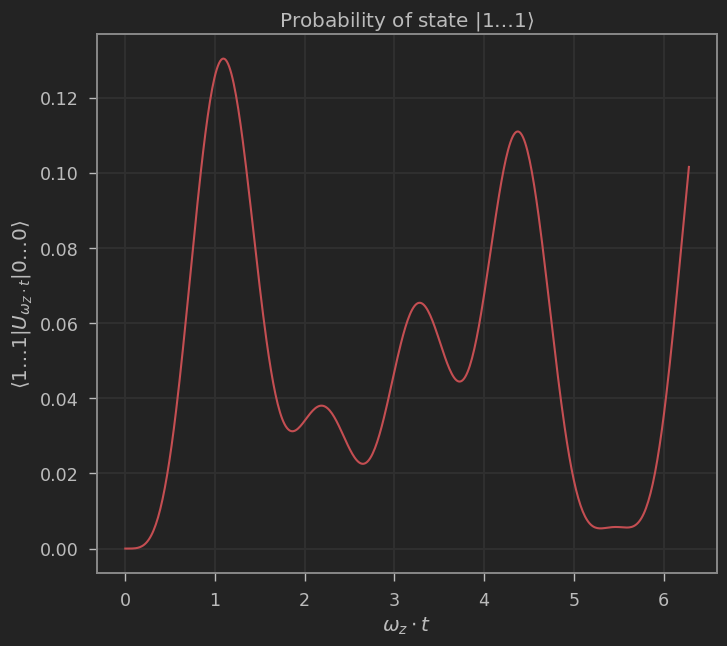

In [7]:
plot(times, probabilities, '-r')
xlabel(r'$\omega_z \cdot t$')
ylabel(r'$\langle 1\dots 1|U_{\omega_Z\cdot t}|0\dots0\rangle$')
title(r'Probability of state $|1\dots1\rangle$')
show()

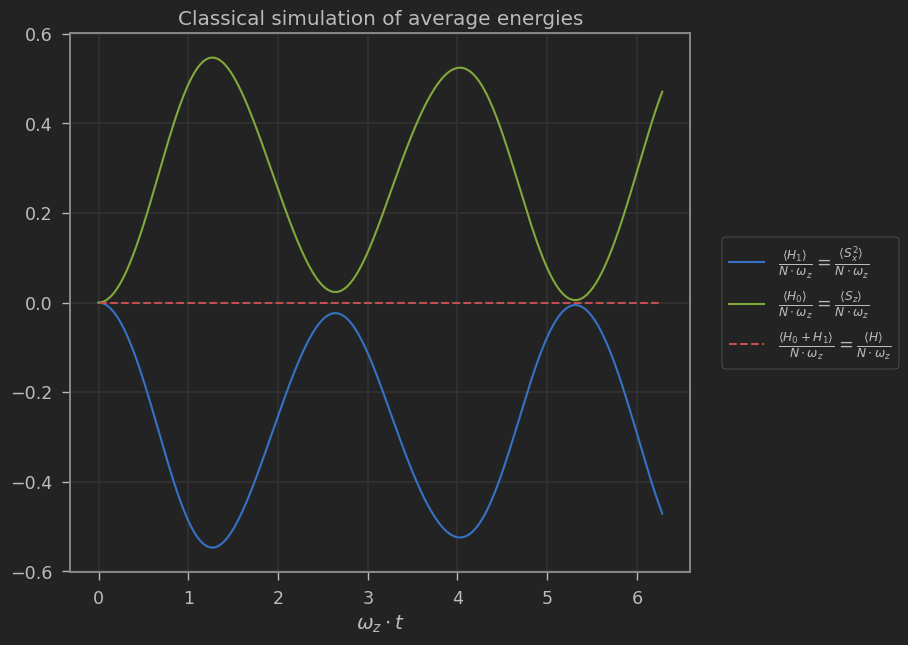

In [8]:
plot(times, coupling_energy, label = r'$\frac{\langle H_1\rangle}{N\cdot\omega_z}=\frac{\langle S_x^2\rangle}{N\cdot\omega_z} $' )    
plot(times, internal_energy, label = r'$\frac{\langle H_0\rangle}{N\cdot\omega_z}=\frac{\langle S_z\rangle}{N\cdot\omega_z} $' )  
plot(times, internal_energy + coupling_energy, '--', label = r'$\frac{\langle H_0 + H_1\rangle}{N\cdot\omega_z}=\frac{\langle H\rangle}{N\cdot\omega_z} $' )  
legend(loc = 'center right', bbox_to_anchor = (1.35, 0.5))
title(r'Classical simulation of average energies')
xlabel(r'$\omega_z \cdot t$')
show()

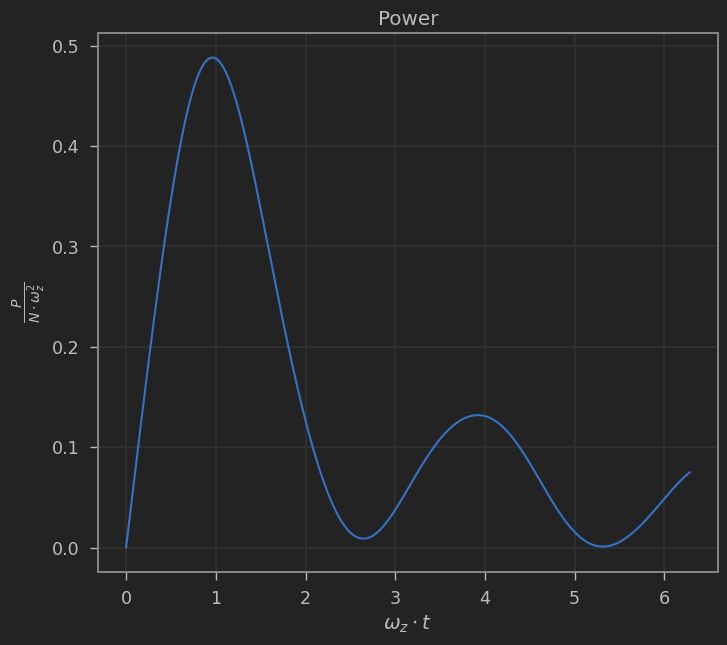

In [9]:
plot(times, divide(internal_energy, times, out = zeros_like(internal_energy), where = times != 0))
title(r'Power')
ylabel(r'$\frac{P}{N\cdot\omega_z^2}$')
xlabel(r'$\omega_z \cdot t$')
show()

In [10]:
%%time
maximum_spins = 7
couplings = arange(0.1, 1.5, 0.1).round(decimals = 2)
maximum_power = array([zeros_like(couplings) for _ in range(maximum_spins - 1)])

for j, g in enumerate(couplings):
    for i in range(2, maximum_spins + 1):
        t, _, energy, _ = classical_simulator([0, 2 * pi], 50, i, frequency, g)
        power = divide(energy, t, out = zeros_like(energy), where = t != 0)
        maximum_power[1 - i][j] = power.max()

CPU times: user 18.1 s, sys: 489 ms, total: 18.6 s
Wall time: 4.69 s


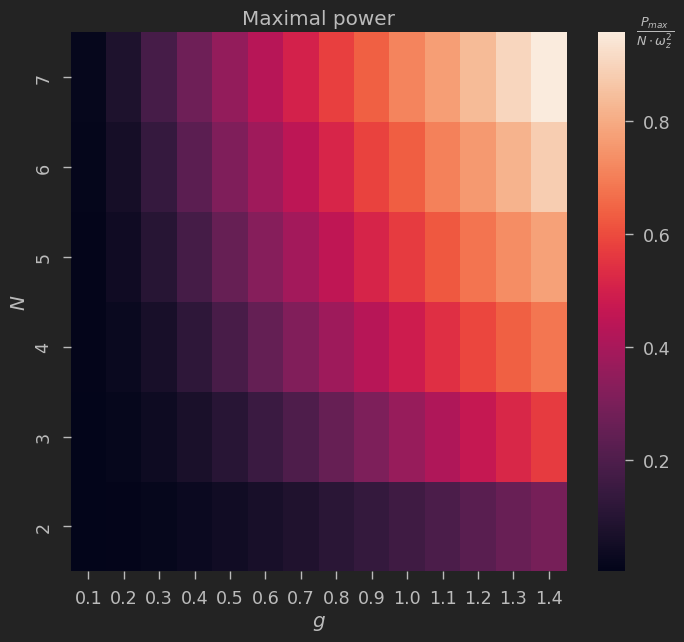

In [11]:
figure = heatmap(maximum_power, xticklabels = couplings, yticklabels = [i for i in range(maximum_spins, 1, -1)])
title('Maximal power')
xlabel(r'$g$')
ylabel(r'$N$')
text(16.5, 0.0, r'$\frac{P_{max}}{N\cdot\omega_z^2}$', horizontalalignment = 'center', verticalalignment = 'center')
show()

### Quantum simulation

In [12]:
quantum_times = linspace(0, 2 * pi / frequency, 50)
shots = 1500

In [13]:
%%time
quantum_probabilities = zeros_like(quantum_times)
quantum_internal_energy = zeros_like(quantum_times)
quantum_coupling_energy = zeros_like(quantum_times)
H0 = quantum_operator_sz(spins) / spins 
H1 = - 2 * coupling * quantum_operator_sxx(spins) / spins / frequency

for i, t in enumerate(quantum_times):
    circuit = trotter_circuit(spins, t, 15, frequency, coupling)
    state_up = state_operator([0 for _ in range(spins)])
    quantum_probabilities[i] = measure_operator(state_up, circuit, shots)
    quantum_internal_energy[i] = measure_operator(H0, circuit, shots) + 1 / 2
    quantum_coupling_energy[i] = measure_operator(H1, circuit, shots)

CPU times: user 16.6 s, sys: 39.9 ms, total: 16.6 s
Wall time: 16.6 s


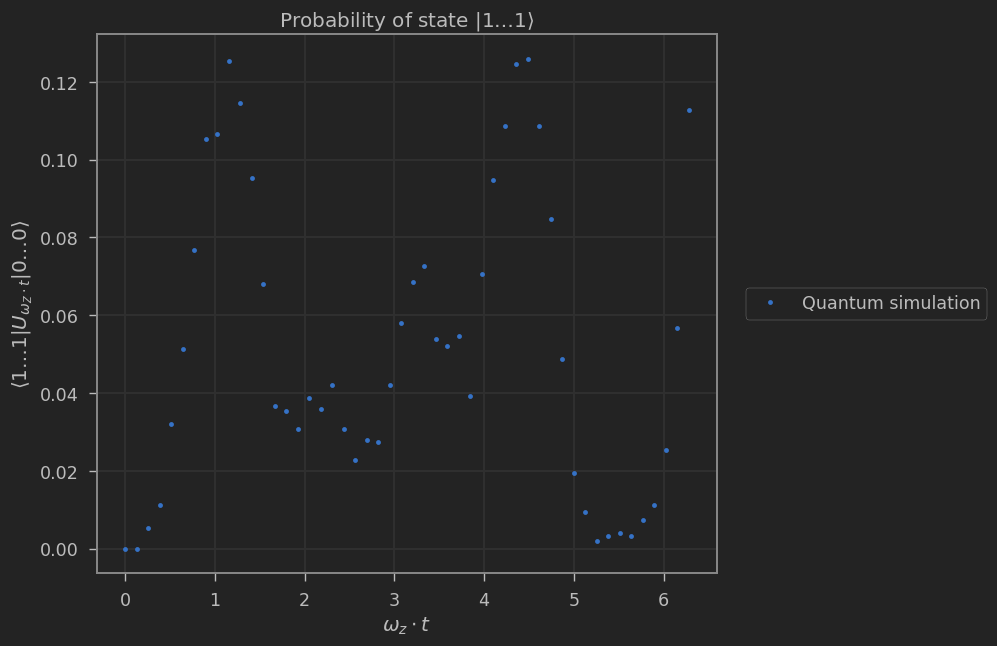

In [14]:
# plot(times, probabilities, '--', label = "Classical simulation")
plot(quantum_times, quantum_probabilities, '.', label = "Quantum simulation")
xlabel(r'$\omega_z \cdot t$')
ylabel(r'$\langle 1\dots 1|U_{\omega_Z\cdot t}|0\dots0\rangle$')
title(r'Probability of state $|1\dots1\rangle$')
legend(loc = 'center right', bbox_to_anchor = (1.45, 0.5))
show()

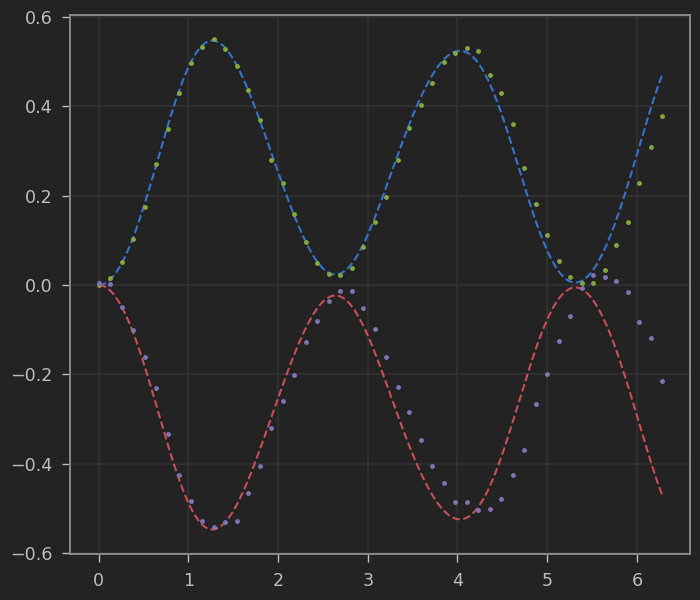

In [15]:
plot(times, internal_energy, '--')
plot(quantum_times, quantum_internal_energy, '.')
plot(times, coupling_energy, '--')
plot(quantum_times, quantum_coupling_energy, '.')
show()

In [16]:
from qiskit import IBMQ

if not IBMQ.active_account():
    if not IBMQ.stored_account():
        with open('Token') as file:
            token = file.readline()

        IBMQ.save_account(token)

    IBMQ.load_account()

backends = IBMQ.providers()[0].backends()
print(backends)

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]
